In [33]:
import keras
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense
from keras.models import Sequential

1st part: classify MNIST using a simple model.

We are going to create a simple Multi-layer perceptron, a simple type of Neural Network, to perform classification tasks on the MNIST digits dataset. If you are not familiar with the MNIST dataset, please consider to read more about it: click here

What is MNIST?

According to LeCun's website, the MNIST is a: "database of handwritten digits that has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image".

Import the MNIST dataset using TensorFlow built-in feature

It's very important to notice that MNIST is a high optimized data-set and it does not contain images. You will need to build your own code if you want to see the real digits. Another important side note is the effort that the authors invested on this data-set with normalization and centering operations.

In [34]:
# import dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The <span style="background-color:#dcdcdc"> one-hot = True</span> argument only means that, in contrast to Binary representation, the labels will be presented in a way that to represent a number N, the $N^{th}$ bit is 1 while the the other bits are 0. For example, five and zero in a binary code would be:

<pre>
Number representation:    0
Binary encoding:        [2^5]  [2^4]   [2^3]   [2^2]   [2^1]   [2^0]  
Array/vector:             0      0       0       0       0       0 

Number representation:    5
Binary encoding:        [2^5]  [2^4]   [2^3]   [2^2]   [2^1]   [2^0]  
Array/vector:             0      0       0       1       0       1  
</pre>

Using a different notation, the same digits using one-hot vector representation can be show as:

<pre>
Number representation:    0
One-hot encoding:        [5]   [4]    [3]    [2]    [1]   [0]  
Array/vector:             0     0      0      0      0     1   

Number representation:    5
One-hot encoding:        [5]   [4]    [3]    [2]    [1]    [0]  
Array/vector:             1     0      0      0      0      0   
</pre>

<h3>Understanding the imported data</h3>

The imported data can be divided as follow:

- Training (mnist.train) >>  Use the given dataset with inputs and related outputs for training of NN. In our case, if you give an image that you know that represents a "nine", this set will tell the neural network that we expect a "nine" as the output.  
        - 55,000 data points
        - mnist.train.images for inputs
        - mnist.train.labels for outputs
  
   
- Validation (mnist.validation) >> The same as training, but now the data is used to generate model properties (classification error, for example) and from this, tune parameters like the optimal number of hidden units or determine a stopping point for the back-propagation algorithm  
        - 5,000 data points
        - mnist.validation.images for inputs
        - mnist.validation.labels for outputs
  
  
- Test (mnist.test) >> the model does not have access to this informations prior to the testing phase. It is used to evaluate the performance and accuracy of the model against "real life situations". No further optimization beyond this point.  
        - 10,000 data points
        - mnist.test.images for inputs
        - mnist.test.labels for outputs

In [35]:
# interactive session: creating coding and run on the fly
sess = tf.InteractiveSession()

<b>Placeholder 'X':</b> represents the "space" allocated input or the images. 
<ul>
    <li>Each input has 784 pixels distributed by a 28 width x 28 height matrix</li>   
    <li>The 'shape' argument defines the tensor size by its dimensions.</li>     
    <li>1st dimension = None. Indicates that the batch size, can be of any size.</li>     
    <li>2nd dimension = 784. Indicates the number of pixels on a single flattened MNIST image.</li>    
</ul>
    
<b>Placeholder 'Y':</b> represents the final output or the labels.
<ul>
    <li>10 possible classes (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)</li>  
    <li>The 'shape' argument defines the tensor size by its dimensions.</li>    
    <li>1st dimension = None. Indicates that the batch size, can be of any size.</li>     
    <li>2nd dimension = 10. Indicates the number of targets/outcomes</li>   
</ul>
<b>dtype for both placeholders:</b> if you not sure, use tf.float32. The limitation here is that the later presented softmax function only accepts float32 or float64 dtypes.

In [36]:
# placeholder to represent the space allocated input or the images
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [37]:
# Assigning bias and weights to null tensors
# Weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

In [38]:
# run the op initilize_all_variables using an interactive session
sess.run(tf.global_variables_initializer())

<b> Adding Weights and Biases to input</b>

The only difference for our next operation to the picture below is that we are using the mathematical convention for what is being executed in the illustration. The tf.matmul operation performs a matrix multiplication between x (inputs) and W (weights) and after the code add biases.


<img src="https://ibm.box.com/shared/static/88ksiymk1xkb10rgk0jwr3jw814jbfxo.png" alt="HTML5 Icon" style="width:400px;height:350px;"> 
<div style="text-align:center">Illustration showing how weights and biases are added to neurons/nodes. </div>

In [39]:
# add weights and biases to input
# mathematical operation to add weights and biases to the inputs
tf.matmul(x,W) + b

<tf.Tensor 'add_4:0' shape=(?, 10) dtype=float32>

<h3>Softmax Regression</h3>

Softmax is an activation function that is normally used in classification problems. It generate the probabilities for the output. For example, our model will not be 100% sure that one digit is the number nine, instead, the answer will be a distribution of probabilities where, if the model is right, the nine number will have a larger probability than the other other digits.

For comparison, below is the one-hot vector for a nine digit label:

0 --> 0  
1 --> 0 
2 --> 0
3 --> 0
4 --> 0
5 --> 0
6 --> 0
7 --> 0
8 --> 0
9 --> 1

A machine does not have all this certainty, so we want to know what is the best guess, but we also want to understand how sure it was and what was the second better option. Below is an example of a hypothetical distribution for a nine digit:


0 -->0.01  
1 -->0.02  
2 -->0.03  
3 -->0.02  
4 -->0.12  
5 -->0.01  
6 -->0.03
7 -->0.06
8 -->0.1
9 -->0.6  



In [40]:
y = tf.nn.softmax(tf.matmul(x,W)+b)

Logistic function output is used for the classification between two target classes 0/1. Softmax function is generalized type of logistic function. That is, Softmax can output a multiclass categorical probability distribution. 

<b>Cost function</b>

It is a function that is used to minimize the difference between the right answers (labels) and estimated outputs by our Network.

In [41]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

Type of optimization: Gradient Descent

This is the part where you configure the optimizer for your Neural Network. There are several optimizers available, in our case we will use Gradient Descent because it is a well established optimizer.

In [42]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

<b>Training batches</b>

In practice, Batch Gradient Descent is not often used because is too computationally expensive. The good part about this method is that you have the true gradient, but with the expensive computing task of using the whole dataset in one time. Due to this problem, Neural Networks usually use minibatch to train.

In [43]:
# load 50 training examples for each training iteration
for i in range(1000):
    batch = mnist.train.next_batch(50)
    train_step.run(feed_dict={x:batch[0], y_:batch[1]})

In [44]:
# Test
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc = accuracy.eval(feed_dict = {x:mnist.test.images, y_:mnist.test.labels}) * 100
print("The final accuracy for the simple AA model is :{}".format(acc))

The final accuracy for the simple AA model is :90.60999751091003


In [48]:
sess.close()

<a id="ref6"></a>
<h2>2nd part: Deep Learning applied on MNIST</h2>

In the first part, we learned how to use a simple ANN to classify MNIST. Now we are going to expand our knowledge using a Deep Neural Network. 


Architecture of our network is:
    
- (Input) -> [batch_size, 28, 28, 1]  >> Apply 32 filter of [5x5]
- (Convolutional layer 1)  -> [batch_size, 28, 28, 32]
- (ReLU 1)  -> [?, 28, 28, 32]
- (Max pooling 1) -> [?, 14, 14, 32]
- (Convolutional layer 2)  -> [?, 14, 14, 64] 
- (ReLU 2)  -> [?, 14, 14, 64] 
- (Max pooling 2)  -> [?, 7, 7, 64] 
- [fully connected layer 3] -> [1x1024]
- [ReLU 3]  -> [1x1024]
- [Drop out]  -> [1x1024]
- [fully connected layer 4] -> [1x10]


The next cells will explore this new architecture.

In [49]:
# start a new interactive session
sess = tf.InteractiveSession()

In [50]:
# get data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<h3>Initial parameters</h3>

Create general parameters for the model

In [51]:
width = 28 # width of the image in pixels
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image
class_output = 10 # number of possibe classifications for the problem

<h3>Input and output</h3>

Create place holders for inputs and outputs

In [52]:
x = tf.placeholder(tf.float32, shape=[None, flat])
y_ = tf.placeholder(tf.float32, shape=[None, class_output])

<h4>Converting images of the data set to tensors</h4>

The input image is 28 pixels by 28 pixels, 1 channel (grayscale). In this case, the first dimension is the <b>batch number</b> of the image, and can be of any size (so we set it to -1). The second and third dimensions are width and height, and the last one is the image channels.


In [54]:
x_image = tf.reshape(x,[-1,width,height,1])
x_image

<tf.Tensor 'Reshape:0' shape=(?, 28, 28, 1) dtype=float32>

<h3>Convolutional Layer 1</h3>

<h4>Defining kernel weight and bias</h4>
We define a kernel here. The Size of the filter/kernel is 5x5;  Input channels is 1 (grayscale);  and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So, the output of convolution layer would be 28x28x32). In this step, we create a filter / kernel tensor of shape <code>[filter_height, filter_width, in_channels, out_channels]</code>

In [56]:
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev = 0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs

<img src="https://ibm.box.com/shared/static/vn26neef1nnv2oxn5cb3uueowcawhkgb.png" style="width: 800px; height: 400px;" alt="HTML5 Icon" >

</h4>Convolve with weight tensor and add biases.</h4>

To create convolutional layer, we use <b>tf.nn.conv2d</b>. It computes a 2-D convolution given 4-D input and filter tensors.

Inputs:
- tensor of shape [batch, in_height, in_width, in_channels]. x of shape [batch_size,28 ,28, 1]
- a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]. W is of size [5, 5, 1, 32]
- stride which is  [1, 1, 1, 1]. The convolutional layer, slides the "kernel window" across the input tensor. As the input tensor has 4 dimensions:  [batch, height, width, channels], then the convolution operates on a 2D window on the height and width dimensions. __strides__ determines how much the window shifts by in each of the dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we could set other values, e.g. [1, 2, 2, 1]
    
    
Process:
- Change the filter to a 2-D matrix with shape [5\*5\*1,32]
- Extracts image patches from the input tensor to form a *virtual* tensor of shape `[batch, 28, 28, 5*5*1]`.
- For each batch, right-multiplies the filter matrix and the image vector.

Output:
- A `Tensor` (a 2-D convolution) of size tf.Tensor 'add_7:0' shape=(?, 28, 28, 32)- Notice: the output of the first convolution layer is 32 [28x28] images. Here 32 is considered as volume/depth of the output image.

In [57]:
convolve1 = tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME') + b_conv1

<h4>Apply the ReLU activation Function</h4>
In this step, we just go through all outputs convolution layer, <b>convolve1</b>, and wherever a negative number occurs, we swap it out for a 0. It is called ReLU activation Function.<br> Let f(x) is a ReLU activation function $f(x) = max(0,x)$.

In [59]:
h_conv1 = tf.nn.relu(convolve1)

<h4>Apply the max pooling</h4>

<b>max pooling</b> is a form of non-linear down-sampling. It partitions the input image into a set of rectangles and, and then find the maximum value for that region. 

Lets use <b>tf.nn.max_pool</b> function to perform max pooling. 
<b>Kernel size:</b> 2x2 (if the window is a 2x2 matrix, it would result in one output pixel)  
<b>Strides:</b> dictates the sliding behaviour of the kernel. In this case it will move 2 pixels everytime, thus not overlapping. The input is a matrix of size 28x28x32, and the output would be a matrix of size 14x14x32.

<img src="https://ibm.box.com/shared/static/kmaja90mn3aud9mro9cn8pbbg1h5pejy.png" alt="HTML5 Icon" style="width: 800px; height: 400px;"> 


In [61]:
conv1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') #max_pool_2*2
conv1

<tf.Tensor 'MaxPool_1:0' shape=(?, 14, 14, 32) dtype=float32>

First layer completed

<h3>Convolutional Layer 2</h3>
<h4>Weights and Biases of kernels</h4>

We apply the convolution again in this layer. Lets look at the second layer kernel:  
- Filter/kernel: 5x5 (25 pixels) 
- Input channels: 32 (from the 1st Conv layer, we had 32 feature maps) 
- 64 output feature maps  

<b>Notice:</b> here, the input image is [14x14x32], the filter is [5x5x32], we use 64 filters of size [5x5x32], and the output of the convolutional layer would be 64 convolved image, [14x14x64].

<b>Notice:</b> the convolution result of applying a filter of size [5x5x32] on image of size [14x14x32] is an image of size [14x14x1], that is, the convolution is functioning on volume.

In [63]:
W_conv2 = tf.Variable(tf.truncated_normal([5,5,32,64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) # need 64 biases for 64 outputs

<h4>Convolve image with weight tensor and add biases.</h4>

In [65]:
convolve2 = tf.nn.conv2d(conv1, W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2

<h4>Apply the ReLU activation Function</h4>

In [66]:
h_conv2 = tf.nn.relu(convolve2)

<h4>Apply the max pooling</h4>

In [68]:
conv2 = tf.nn.max_pool(h_conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') #max_pool_2*2
conv2

<tf.Tensor 'MaxPool_2:0' shape=(?, 7, 7, 64) dtype=float32>

Second layer completed. So, what is the output of the second layer, layer2?
- it is 64 matrix of [7x7]


<h3>Fully Connected Layer</h3>
You need a fully connected layer to use the Softmax and create the probabilities in the end. Fully connected layers take the high-level filtered images from previous layer, that is all 64 matrices, and convert them to a flat array.

So, each matrix [7x7] will be converted to a matrix of [49x1], and then all of the 64 matrix will be connected, which make an array of size [3136x1]. We will connect it into another layer of size [1024x1]. So, the weight between these 2 layers will be [3136x1024]


<img src="https://ibm.box.com/shared/static/pr9mnirmlrzm2bitf1d4jj389hyvv7ey.png" alt="HTML5 Icon" style="width: 800px; height: 400px;"> 


<h4>Flattening Second Layer</h4>

In [83]:
layer2_matrix = tf.reshape(conv2, [-1, 7*7*64])

<h4>Weights and Biases between layer 2 and 3</h4>

Composition of the feature map from the last layer (7x7) multiplied by the number of feature maps (64); 1027 outputs to Softmax layer

In [84]:
W_fc1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))  # need 1024 biases for 1024 outputs

<h4>Matrix Multiplication (applying weights and biases)</h4>

In [85]:
fcl = tf.matmul(layer2_matrix, W_fc1) + b_fc1

<h4>Apply the ReLU activation Function</h4>

In [86]:
h_fcl = tf.nn.relu(fcl)
h_fcl

<tf.Tensor 'Relu_2:0' shape=(?, 1024) dtype=float32>

Third layer completed
<h4>Dropout Layer, Optional phase for reducing overfitting</h4>

It is a phase where the network "forget" some features. At each training step in a mini-batch, some units get switched off randomly so that it will not interact with the network. That is, it weights cannot be updated, nor affect the learning of the other network nodes.  This can be very useful for very large neural networks to prevent overfitting.

In [89]:
keep_prob = tf.placeholder(tf.float32)
layer_drop = tf.nn.dropout(h_fcl, keep_prob)
layer_drop

<tf.Tensor 'dropout_1/mul:0' shape=(?, 1024) dtype=float32>

<h4>Readout Layer (Softmax Layer)</h4>
Type: Softmax, Fully Connected Layer.
<h4>Weights and Biases</h4>
In last layer, CNN takes the high-level filtered images and translate them into votes using softmax.
Input channels: 1024 (neurons from the 3rd Layer); 10 output features

In [91]:
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))  # 1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))  # 10 possibilities for digits [0,1,2,3,4,5,6,7,8,9]

<h4>Matrix Multiplication (applying weights and biases)</h4>

In [93]:
fc = tf.matmul(layer_drop, W_fc2) +b_fc2

<h4>Apply the Softmax activation Function</h4>
<b>softmax</b> allows us to interpret the outputs of <b>fcl4</b> as probabilities. So, <b>y_conv</b> is a tensor of probabilities.

In [94]:
y_CNN = tf.nn.softmax(fc)
y_CNN

<tf.Tensor 'Softmax_3:0' shape=(?, 10) dtype=float32>

<a id="ref7"></a>
<h2>Summary of the Deep Convolutional Neural Network</h2>

Now is time to remember the structure of  our network

#### 0) Input - MNIST dataset
#### 1) Convolutional and Max-Pooling
#### 2) Convolutional and Max-Pooling
#### 3) Fully Connected Layer
#### 4) Processing - Dropout
#### 5) Readout layer - Fully Connected
#### 6) Outputs - Classified digits

<a id="ref8"></a>
<h2>Define functions and train the model</h2>
<h4>Define the loss function</h4>

We need to compare our output, layer4 tensor, with ground truth for all mini_batch. we can use <b>cross entropy>/b> to see how bad our CNN is working - to measure the error at a softmax layer.

The following code shows an toy sample of cross-entropy for a mini-batch of size 2 which its items have been classified. You can run it (first change the cell type to <b>code</b> in the toolbar) to see how cross entropy changes.

In [95]:
import numpy as np
layer4_test =[[0.9, 0.1, 0.1],[0.9, 0.1, 0.1]]
y_test=[[1.0, 0.0, 0.0],[1.0, 0.0, 0.0]]
np.mean( -np.sum(y_test * np.log(layer4_test),1))

0.10536051565782628

<b>reduce_sum</b> computes the sum of elements of <b>(y_ * tf.log(layer4)</b> across second dimension of the tensor, and <b>reduce_mean</b> computes the mean of all elements in the tensor..

In [96]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_CNN), reduction_indices=[1]))

<h4>Define the optimizer</h4>

It is obvious that we want minimize the error of our network which is calculated by cross_entropy metric. To solve the problem, we have to compute gradients for the loss (which is minimizing the cross-entropy) and apply gradients to variables. It will be done by an optimizer: GradientDescent or Adagrad. 

In [97]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

<h4>Define prediction</h4>
Do you want to know how many of the cases in a mini-batch has been classified correctly? lets count them.

In [98]:
correct_prediction = tf.equal(tf.argmax(y_CNN, 1), tf.argmax(y_, 1))

<h4>Define accuracy</h4>
It makes more sense to report accuracy using average of correct cases.

In [99]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

<h4>Run session, train</h4>

In [100]:
sess.run(tf.global_variables_initializer())

<i>If you want a fast result (<b>it might take sometime to train it</b>)</i>

In [101]:
for i in range(1100):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, float(train_accuracy)))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.14
step 100, training accuracy 0.82
step 200, training accuracy 0.88
step 300, training accuracy 0.94
step 400, training accuracy 0.94
step 500, training accuracy 0.92
step 600, training accuracy 0.88
step 700, training accuracy 1
step 800, training accuracy 0.96
step 900, training accuracy 0.98
step 1000, training accuracy 0.96


<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<font size = 3><strong><i>You can run this cell if you REALLY have time to wait, or you are running it using PowerAI (<b>change the type of the cell to code</b>)</i></strong></font>

<a id="ref9"></a>
<h2>Evaluate the model</h2>

Print the evaluation to the user

In [102]:
# evaluate in batches to avoid out-of-memory issues
n_batches = mnist.test.images.shape[0] // 50
cumulative_accuracy = 0.0
for index in range(n_batches):
    batch = mnist.test.next_batch(50)
    cumulative_accuracy += accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
print("test accuracy {}".format(cumulative_accuracy / n_batches))

test accuracy 0.9669999998807907


<h3>Visualization</h3>
Do you want to look at all the filters?

In [103]:
kernels = sess.run(tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0,1]),[32, -1]))

In [104]:
!wget --output-document utils1.py http://deeplearning.net/tutorial/code/utils.py
import utils1
from utils1 import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels, img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

--2018-12-28 10:58:30--  http://deeplearning.net/tutorial/code/utils.py
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/plain]
Saving to: ‘utils1.py’

utils1.py           100%[=====================>]   4.98K  --.-KB/s   in 0s     

2018-12-28 10:58:31 (256 MB/s) - ‘utils1.py’ saved [5097/5097]

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x182d604d08> (for post_execute):


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Do you want to see the output of an image passing through first convolution layer?

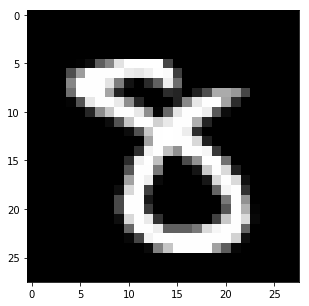

In [105]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage = mnist.test.images[1]
plt.imshow(np.reshape(sampleimage,[28,28]), cmap="gray")

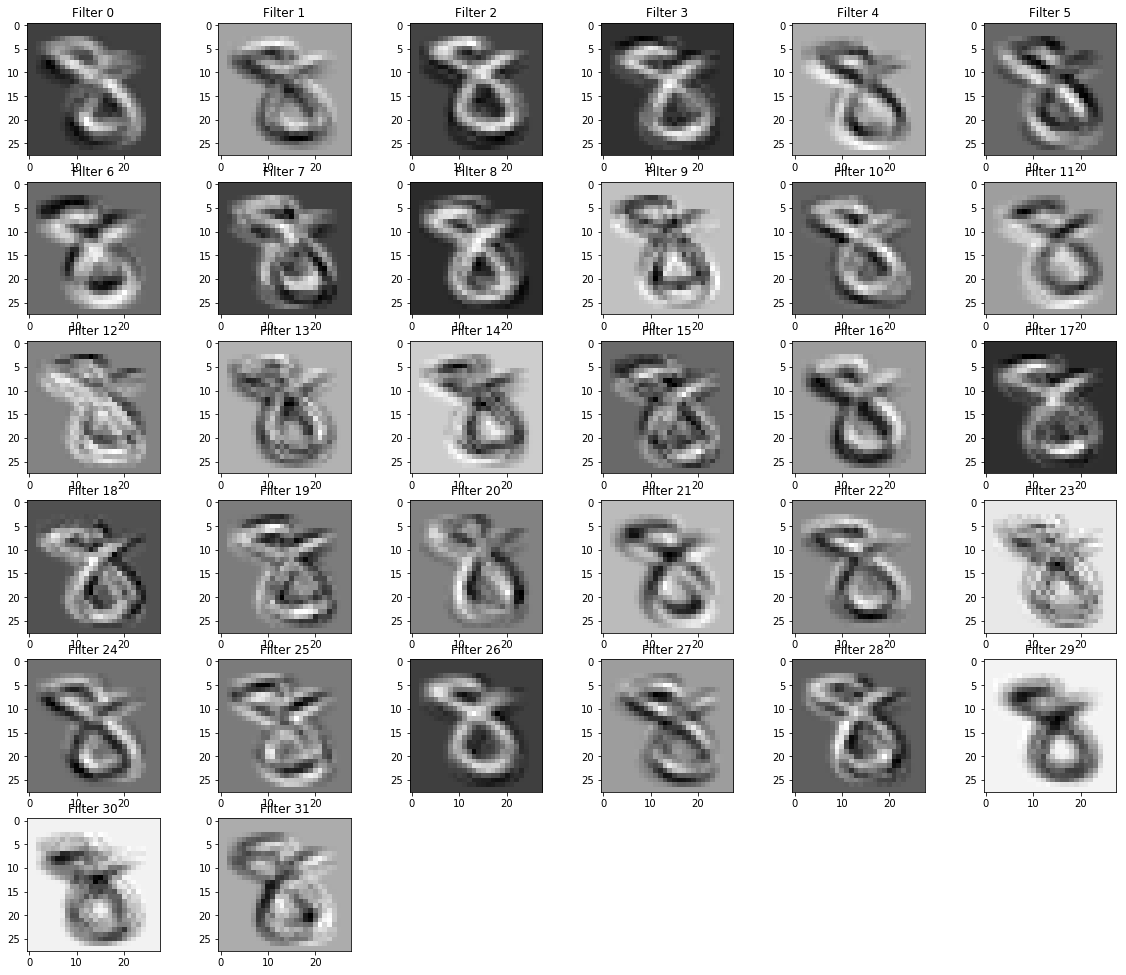

In [106]:


ActivatedUnits = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 6
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")


What about second convolution layer?

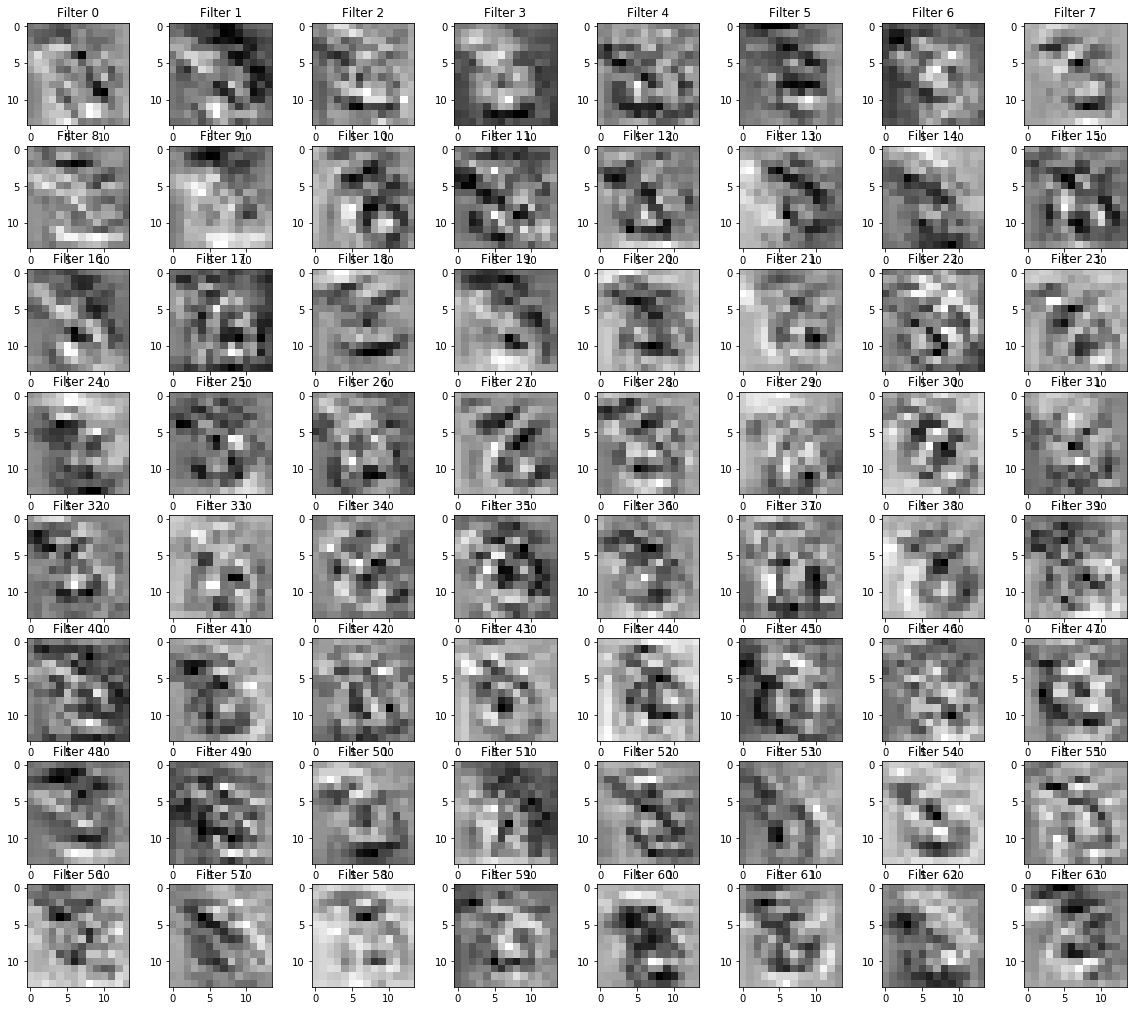

In [107]:
ActivatedUnits = sess.run(convolve2,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

In [108]:
sess.close() #finish the session